In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import xgboost as xgb


def fit_models(df):
    
    df = df.dropna()
    train_size = int(len(df) * 0.9)
    train = df.iloc[:train_size, :]
    test = df.iloc[train_size:, :]

    target_name = df.columns[-1]
    train_X = train.drop(target_name, axis = 1)
    train_y = train[target_name]

    test_X = test.drop(target_name, axis = 1)
    test_y = test[target_name]
    
    models = []
    
    #Decision Tree
    models.append(('DT', DecisionTreeClassifier(max_depth=5)))
    
    # Random Forest
    models.append(('RF', RandomForestClassifier(max_depth=5)))
    
    # Gradient Boosting
    models.append(('GB', GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=5)))
    
    # XGBoost
    models.append(('XGB', xgb.XGBClassifier(use_label_encoder=False, eval_metric='error')))
    models.append(('SVC', SVC()))
    models.append(('KNN', KNeighborsClassifier()))
    
    # Logistic Regression
    models.append(('LR', LogisticRegression()))
    
    # Naive Bayes
    models.append(('NB', GaussianNB()))

    accuracies = dict()

    for name, model in models:

        model.fit(train_X, train_y)
        hyp = model.predict(test_X)
        accuracies[name] = accuracy_score(test_y, hyp) * 100.0
        
    return accuracies

In [2]:
import stock_helper
import pandas as pd
from datetime import datetime
import numpy as np

def date_to_day(df):
    # Convert date to the n-th day from 1970-01-01
    df['date'] = df['date'] \
        .apply(lambda date64: (date64 - np.datetime64('1970-01-01T00:00:00')) / np.timedelta64(1, 'D'))

stocks = ['AAPL', 'GOOG', 'AMD', 'TSLA', 'JPM', 'UAL']
stocks_dataset = [None] * len(stocks)

for i in range(len(stocks)):
    dataset = stock_helper.fetch_stock_data(stocks[i])
    stocks_dataset[i] = stock_helper.generate_indicators(dataset, 
                                     timeperiod=5, 
                                     generate_target=True, 
                                     reset_index=True)
    
    date_to_day(stocks_dataset[i])

In [3]:
dataset_accuracy = dict()
for i, df in enumerate(stocks_dataset):
    dataset_accuracy[stocks[i]] = fit_models(df)


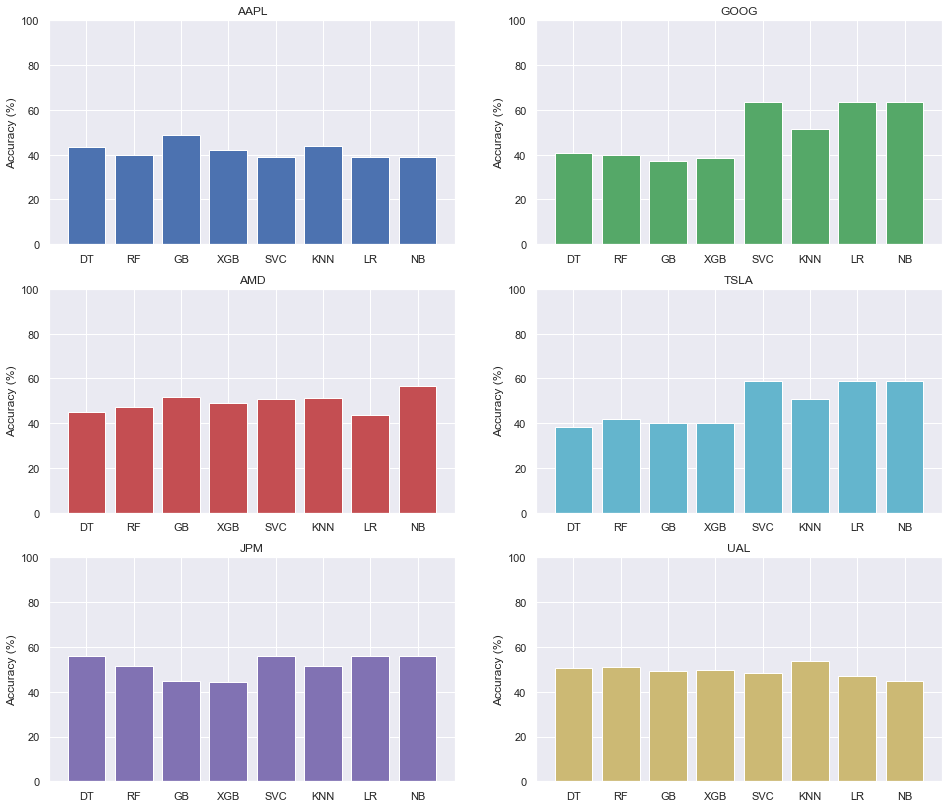

In [20]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16,14))

colors = ['b', 'g', 'r', 'c', 'm', 'y']
i = 0
for stock_name in dataset_accuracy:    
    data = dataset_accuracy[stock_name]
    ax_row = int(i/2)
    ax_colm = i % 2
    ax = axes[ax_row, ax_colm]
    ax.set_ylabel('Accuracy (%)')
    ax.set_ylim(0, 100)
    ax.set_title(stock_name)
    ax.bar(data.keys(), data.values(), color=colors[i])
    i+= 1

In [34]:
for stock_name in dataset_accuracy:
    acc = dataset_accuracy[stock_name]
    highest = sorted(acc, key=acc.get, reverse=True)[:1]
    print("The best model for {stockname} is {model}, accuracy is {acc:.2f}%".format(stockname=stock_name,
                                                                                    model=highest[0],
                                                                                    acc=acc[highest[0]]))

The best model for AAPL is GB, accuracy is 48.92%
The best model for GOOG is SVC, accuracy is 63.40%
The best model for AMD is NB, accuracy is 56.43%
The best model for TSLA is SVC, accuracy is 58.67%
The best model for JPM is DT, accuracy is 56.14%
The best model for UAL is KNN, accuracy is 53.81%


# Tensorflow LSTM

In [92]:
from sklearn import preprocessing

history_points = 50

def get_features(dataset):
    data = dataset.copy()
    
    target_name = data.columns[-1]
    data = data.drop(target_name, axis=1)
    data = data.to_numpy()

    data_normaliser = preprocessing.MinMaxScaler()
    data_normalised = data_normaliser.fit_transform(data)
    
    # get the history_points * 5 features (open, clos, volum, etc) array * (rows - history_points) 
    features = np.array([data_normalised[i  : i + history_points].copy() for i in range(len(data_normalised) - history_points)])
    return features

In [94]:
X = get_features(df)
result = df[target_name].iloc[history_points:]
Y = np.expand_dims(result, axis=-1)
print(len(X))
print(len(Y))

10327
10327


In [ ]:
from sklearn.model_selection import train_test_split

print(X.shape)
print(Y.shape)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)
print(len(x_train))
print(len(x_test))

In [96]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, InputLayer,Embedding,SpatialDropout1D

# model definition
lstm_input = Input(shape=(history_points, 5), name='lstm_input')
x = LSTM(history_points, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
x = Dense(64, name='dense_0')(x)
x = Activation('sigmoid', name='sigmoid_0')(x)
x = Dense(1, name='dense_1')(x)
output = tf.nn.softmax( x )
model = Model(inputs=lstm_input, outputs=output)

model.compile(loss='BinaryCrossentropy', optimizer='adam', metrics=['accuracy'])

In [97]:
model.fit(x=train_X,
          y=train_y,
          batch_size=32,
          epochs=25)

Epoch 1/25


ValueError: in user code:

    /opt/anaconda3/envs/cs663/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /opt/anaconda3/envs/cs663/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/anaconda3/envs/cs663/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/anaconda3/envs/cs663/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/anaconda3/envs/cs663/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/anaconda3/envs/cs663/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /opt/anaconda3/envs/cs663/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /opt/anaconda3/envs/cs663/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/anaconda3/envs/cs663/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:271 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model_1: expected shape=(None, 50, 5), found shape=(None, 18)


In [382]:
evaluation = model.evaluate(test_X, test_y)
print(evaluation)

33/33 [==============================] - 1s 7ms/step - loss: 6.7027 - accuracy: 0.5605
[6.679781913757324, 0.5619596838951111]
